<a href="https://colab.research.google.com/github/Anushka-999/Zomato-Data-Analysis/blob/main/Zomato_Data_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install pandas numpy matplotlib seaborn scikit-learn


In [ ]:
###############################################################
# 1. IMPORT LIBRARIES
###############################################################
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# For modeling
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# To ignore some harmless warnings
import warnings
warnings.filterwarnings('ignore')

In [ ]:
###############################################################
# 2. LOAD DATA
###############################################################
# Replace 'zomato.csv' with the actual path to your dataset
df = pd.read_csv('/content/zomato.csv', encoding='utf-8', engine='python', on_bad_lines='skip')

# Peek at first few rows
print("===== HEAD OF THE DATA =====")
print(df.head())

# Check shape (rows, columns)
print("\nDataset Shape:", df.shape)

===== HEAD OF THE DATA =====
                                                 url  \
0  https://www.zomato.com/bangalore/jalsa-banasha...   
1  https://www.zomato.com/bangalore/spice-elephan...   
2  https://www.zomato.com/SanchurroBangalore?cont...   
3  https://www.zomato.com/bangalore/addhuri-udupi...   
4  https://www.zomato.com/bangalore/grand-village...   

                                             address                   name  \
0  942, 21st Main Road, 2nd Stage, Banashankari, ...                  Jalsa   
1  2nd Floor, 80 Feet Road, Near Big Bazaar, 6th ...         Spice Elephant   
2  1112, Next to KIMS Medical College, 17th Cross...        San Churro Cafe   
3  1st Floor, Annakuteera, 3rd Stage, Banashankar...  Addhuri Udupi Bhojana   
4  10, 3rd Floor, Lakshmi Associates, Gandhi Baza...          Grand Village   

  online_order book_table   rate  votes                             phone  \
0          Yes        Yes  4.1/5    775    080 42297555\r\n+91 9743772233   
1    

In [ ]:
###############################################################
# 3. INITIAL DATA INSPECTION
###############################################################
# Check column names and data types
print("\n===== DATAFRAME INFO =====")
print(df.info())

# Check for missing values
print("\n===== MISSING VALUES =====")
print(df.isnull().sum())

# (Optional) Look at some descriptive statistics for numeric columns
print("\n===== DESCRIPTIVE STATISTICS =====")
print(df.describe(include='all'))


===== DATAFRAME INFO =====
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51155 entries, 0 to 51154
Data columns (total 17 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   url                          51155 non-null  object
 1   address                      51155 non-null  object
 2   name                         51155 non-null  object
 3   online_order                 51155 non-null  object
 4   book_table                   51155 non-null  object
 5   rate                         43380 non-null  object
 6   votes                        51155 non-null  int64 
 7   phone                        49952 non-null  object
 8   location                     51134 non-null  object
 9   rest_type                    50931 non-null  object
 10  dish_liked                   23081 non-null  object
 11  cuisines                     51110 non-null  object
 12  approx_cost(for two people)  50811 non-null  object
 13  rev

In [ ]:
###############################################################
# 4. DATA CLEANING & FEATURE ENGINEERING
###############################################################

# ---- 4.1 Clean the 'rate' column ----
# The 'rate' column often looks like '4.1/5'. We'll extract the numeric part.
def extract_rating(x):
    """
    Extracts the numeric rating (e.g., '4.1/5' -> 4.1).
    If 'NEW' or '-' or invalid, return NaN.
    """
    if isinstance(x, str):
        x = x.strip()
        if '/' in x:
            # split on '/', take first part
            num_str = x.split('/')[0]
            # handle edge cases
            if num_str.replace('.', '').isdigit():
                return float(num_str)
        # If string but not containing '/', possibly 'NEW' or '-'
        return np.nan
    return np.nan

df['rating'] = df['rate'].apply(extract_rating)
# Drop original 'rate' column if you want to avoid confusion
df.drop('rate', axis=1, inplace=True)

# ---- 4.2 Clean the 'approx_cost(for two people)' column ----
# This column can contain commas or be an object. Convert to numeric.
df['approx_cost'] = (
    df['approx_cost(for two people)']
    .astype(str)
    .str.replace('[^0-9]', '', regex=True)  # remove non-numeric chars
    .replace('', np.nan)                    # if empty, set to NaN
    .astype(float)
)

# Drop the original column if desired
df.drop('approx_cost(for two people)', axis=1, inplace=True)

# ---- 4.3 Convert categorical columns (Yes/No) to numeric or keep as category ----
# For example: 'online_order' -> 1 if 'Yes', 0 if 'No'
df['online_order'] = df['online_order'].map({'Yes': 1, 'No': 0})
df['book_table']   = df['book_table'].map({'Yes': 1, 'No': 0})

# ---- 4.4 Handle missing values in 'rating' or 'approx_cost' if needed ----
# Simple approach: drop rows with missing rating or cost
df.dropna(subset=['rating', 'approx_cost'], inplace=True)

# (Optional) Fill missing votes with 0 if that makes sense
df['votes'] = df['votes'].fillna(0)

# ---- 4.5 Check duplicates ----
df.drop_duplicates(subset=['url', 'phone', 'name'], inplace=True)

# Re-check the shape
print("\nDataset Shape After Cleaning:", df.shape)



Dataset Shape After Cleaning: (21084, 17)


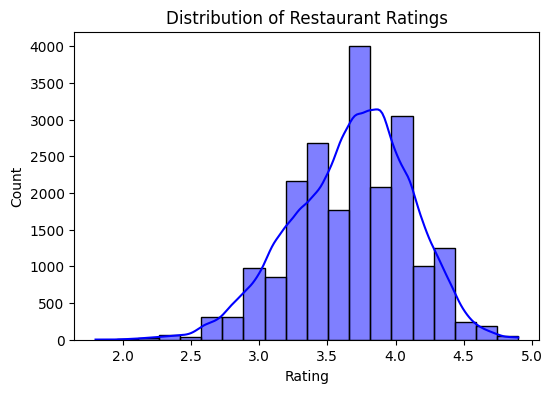

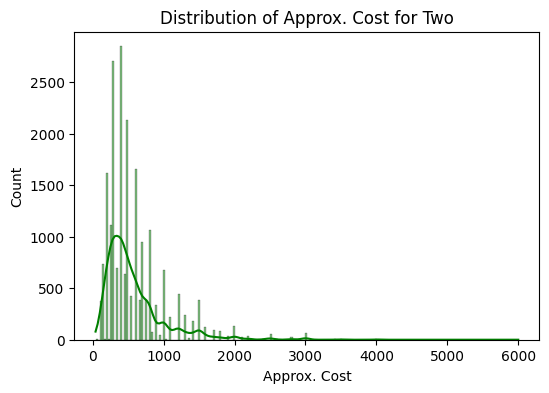

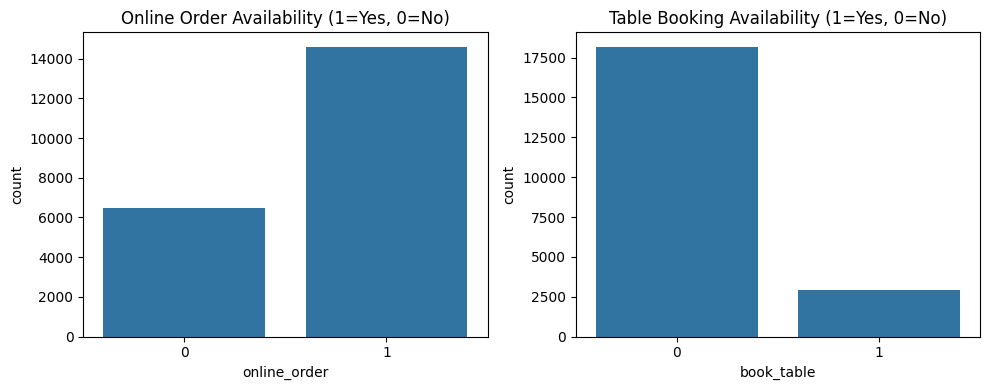

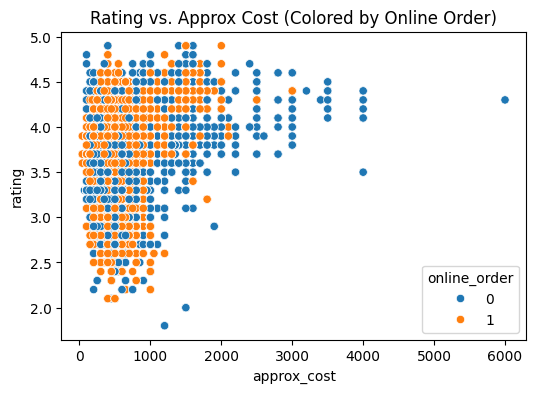

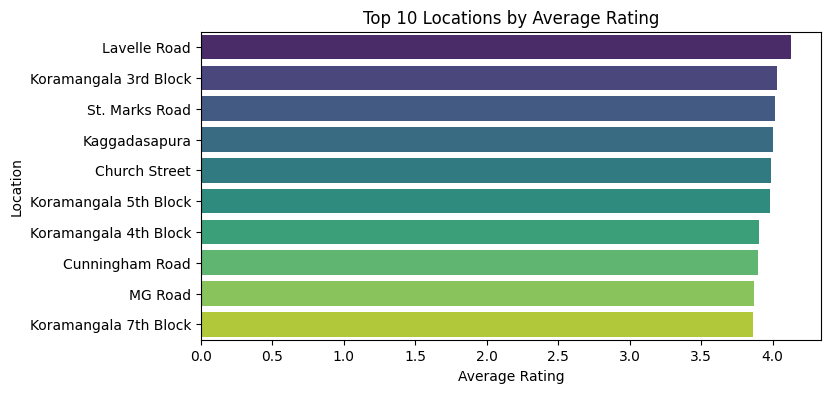

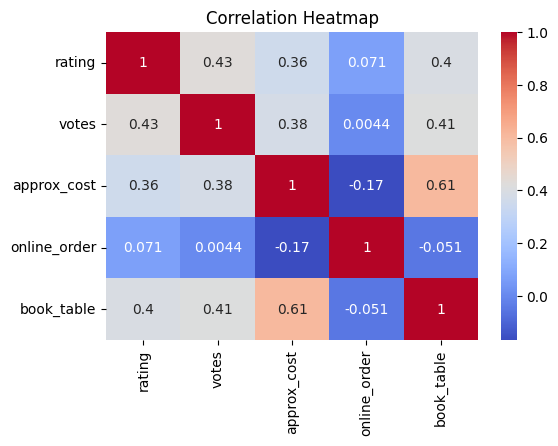

In [ ]:
###############################################################
# 5. EXPLORATORY DATA ANALYSIS (EDA)
###############################################################

# ---- 5.1 Distribution of Ratings ----
plt.figure(figsize=(6,4))
sns.histplot(df['rating'], kde=True, bins=20, color='blue')
plt.title('Distribution of Restaurant Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

# ---- 5.2 Distribution of Approximate Cost ----
plt.figure(figsize=(6,4))
sns.histplot(df['approx_cost'], kde=True, color='green')
plt.title('Distribution of Approx. Cost for Two')
plt.xlabel('Approx. Cost')
plt.ylabel('Count')
plt.show()

# ---- 5.3 Online Order / Book Table Counts ----
fig, ax = plt.subplots(1,2, figsize=(10,4))

sns.countplot(x='online_order', data=df, ax=ax[0])
ax[0].set_title('Online Order Availability (1=Yes, 0=No)')

sns.countplot(x='book_table', data=df, ax=ax[1])
ax[1].set_title('Table Booking Availability (1=Yes, 0=No)')

plt.tight_layout()
plt.show()

# ---- 5.4 Relationship: Rating vs. Approx Cost ----
plt.figure(figsize=(6,4))
sns.scatterplot(data=df, x='approx_cost', y='rating', hue='online_order')
plt.title('Rating vs. Approx Cost (Colored by Online Order)')
plt.show()

# ---- 5.5 Average Rating by Location ----
# If 'location' has too many categories, you might focus on top 10 or so
location_rating = df.groupby('location')['rating'].mean().sort_values(ascending=False).head(10)
plt.figure(figsize=(8,4))
sns.barplot(x=location_rating.values, y=location_rating.index, palette='viridis')
plt.title('Top 10 Locations by Average Rating')
plt.xlabel('Average Rating')
plt.ylabel('Location')
plt.show()

# ---- 5.6 Correlation Heatmap (numeric features) ----
numeric_cols = ['rating', 'votes', 'approx_cost', 'online_order', 'book_table']
corr = df[numeric_cols].corr()
plt.figure(figsize=(6,4))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()



===== MODEL EVALUATION (Random Forest) =====
MSE  : 0.028819224237944183
RMSE : 0.16976225799023817
R^2  : 0.8419515724573037

===== FEATURE IMPORTANCE =====
            feature  importance
0             votes    0.625746
4  location_encoded    0.176522
1       approx_cost    0.151988
2      online_order    0.029615
3        book_table    0.016129


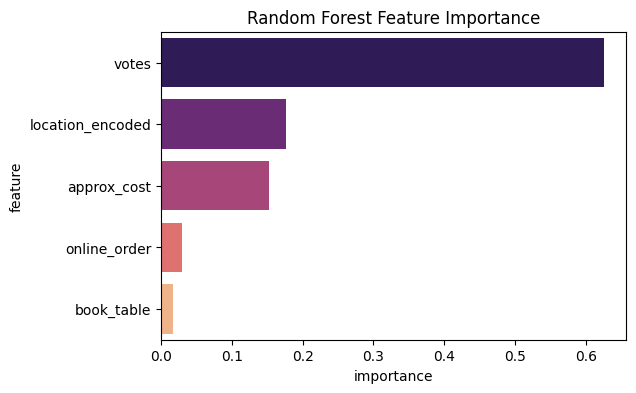

In [ ]:
###############################################################
# 6. BASIC STATISTICAL MODELING
#    (Predict Restaurant Rating based on available features)
###############################################################

# We'll try a simple regression approach:
#   Target: rating
#   Features: votes, approx_cost, online_order, book_table, location (encoded)

# ---- 6.1 Encode 'location' (if many unique values, consider grouping) ----
# For demonstration, let's do a simple label encoding
df['location'] = df['location'].astype('category')
df['location_encoded'] = df['location'].cat.codes  # integer codes

# ---- 6.2 Prepare Feature Matrix X and Target y ----
X = df[['votes', 'approx_cost', 'online_order', 'book_table', 'location_encoded']]
y = df['rating']

# ---- 6.3 Train-Test Split ----
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    random_state=42)

# ---- 6.4 Train a Random Forest Regressor ----
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# ---- 6.5 Predict and Evaluate ----
y_pred = rf.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("\n===== MODEL EVALUATION (Random Forest) =====")
print("MSE  :", mse)
print("RMSE :", rmse)
print("R^2  :", r2)

# ---- 6.6 Feature Importance ----
importances = rf.feature_importances_
feature_names = X.columns
feat_imp = pd.DataFrame({'feature': feature_names, 'importance': importances})
feat_imp.sort_values(by='importance', ascending=False, inplace=True)
print("\n===== FEATURE IMPORTANCE =====")
print(feat_imp)

plt.figure(figsize=(6,4))
sns.barplot(x='importance', y='feature', data=feat_imp, palette='magma')
plt.title('Random Forest Feature Importance')
plt.show()

In [ ]:
###############################################################
# 7. INSIGHT GENERATION
###############################################################
# In a real project, you'd interpret the results:
# - Check which features drive rating the most
# - Summarize EDA findings (e.g., top locations, cost vs. rating patterns, etc.)
# - Possibly refine the model or do more advanced analyses (like text analysis of 'reviews_list')

print("\n===== INSIGHTS & NEXT STEPS =====")
print("""
1. Locations with highest average ratings (see bar chart) might be prime areas
   for new restaurants or expansions.
2. The correlation heatmap suggests that 'votes' and 'approx_cost' have some
   relationship with 'rating'. (Though not always very strong.)
3. The model's R^2 suggests how much of the rating variance is explained by
   the chosen features. If it's low, we may need more features or better
   feature engineering (like analyzing reviews or cuisine types).
4. Online ordering (1/0) might also influence rating slightly, as seen in the
   scatter plot or correlation matrix.
5. Additional advanced steps could include:
   - Text sentiment analysis on 'reviews_list'
   - Clustering restaurants based on cost, location, rating, cuisine
   - Building a classification model for rating ranges (e.g., High vs. Low).
6. Export cleaned data to CSV and import into Power BI for interactive
   dashboards, where you can build visual narratives and share insights
   with stakeholders.
""")



===== INSIGHTS & NEXT STEPS =====

1. Locations with highest average ratings (see bar chart) might be prime areas
   for new restaurants or expansions.
2. The correlation heatmap suggests that 'votes' and 'approx_cost' have some
   relationship with 'rating'. (Though not always very strong.)
3. The model's R^2 suggests how much of the rating variance is explained by 
   the chosen features. If it's low, we may need more features or better 
   feature engineering (like analyzing reviews or cuisine types).
4. Online ordering (1/0) might also influence rating slightly, as seen in the
   scatter plot or correlation matrix.
5. Additional advanced steps could include:
   - Text sentiment analysis on 'reviews_list'
   - Clustering restaurants based on cost, location, rating, cuisine
   - Building a classification model for rating ranges (e.g., High vs. Low).
6. Export cleaned data to CSV and import into Power BI for interactive
   dashboards, where you can build visual narratives and share i

In [ ]:
df.to_csv('cleaned_zomato.csv', index=False)
